In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
# Parameters #

r_R = 5 
p = 0.975
K_R = 2500
d_R = 0.2
beta = 4.7
m = 20
g = 0.02
a = 0.004
r_F = 20
d_F = 10
K_F = 6.57

In [63]:
# The Model #

def f(X, t):
    
    S = int(X[0])
    I = int(X[1])
    R = int(X[2])
    N = X[3]
    F = int(X[4])
    
    T = S+I+R
    
    # rates #
    
    birth_S_from_R = r_R*R*(1-p) #S+1
    
    birth_S_pos = max(r_R*S*(1-T/K_R), 0) #S+1 if positive, 0 if negative
    birth_R_pos = max(r_R*R*(p-T/K_R), 0) #R+1 if positive, 0 if negative
    birth_N_pos = max(r_F*N*(1-N/K_F)*T, 0) #N+(1/T) if positive, 0 if negative
    
    birth_S_neg = -min(r_R*S*(1-T/K_R), 0) #0 if positive, S-1 if negative
    birth_R_neg = -min(r_R*R*(p-T/K_R), 0) #0 if positive, R-1 if negative
    birth_N_neg = -min(r_F*N*(1-N/K_F)*T, 0) #0 if positive, N-(1/T) if negative
    
    death_S = d_R*S #S-1
    death_I = d_R*I #I-1, F+N
    death_R = d_R*R #R-1
    death_F = d_F*F #F-1
    
    recovery = m*g*I #I-1, R+1
    disease_death = m*(1-g)*I #I-1, F+N
    
    new_host_no_infection = (d_F-beta*S/T)*F*(1-np.exp(-a*T)) #N+(1/T)
    new_host_with_infection = beta*S*F*(1-np.exp(-a*T))/T #S-1, I+1, N+(1/T)
    
    
    overall_rate = (birth_S_from_R 
                    + birth_S_pos + birth_R_pos + birth_N_pos 
                    + birth_S_neg + birth_R_neg + birth_N_neg 
                    + death_S + death_I + death_R + death_F
                    + recovery + disease_death 
                    + new_host_no_infection + new_host_with_infection)
    
    prob = (1/overall_rate)*np.array([birth_S_from_R, 
                                      birth_S_pos, birth_R_pos, birth_N_pos,
                                      birth_S_neg, birth_R_neg, birth_N_neg, 
                                      death_S, death_I, death_R, death_F, 
                                      recovery, disease_death, 
                                      new_host_no_infection, new_host_with_infection])
    
    for i in range(len(prob)):
        if prob[i]<0: print(prob[i], i, F)
    
    # random interevent time #
    
    dt = np.random.exponential(1/overall_rate)
    
    # random event #
    
    event_index = np.random.choice(15, p=prob)
    
    events = ([[S+1, I, R, N, F, t+dt], 
               [S+1, I, R, N, F, t+dt], [S, I, R+1, N, F, t+dt], [S, I, R, N+(1/T), F, t+dt], 
               [S-1, I, R, N, F, t+dt], [S, I, R-1, N, F, t+dt], [S, I, R, N-(1/T), F, t+dt], 
               [S-1, I, R, N, F, t+dt], [S, I-1, R, N, F+N, t+dt], [S, I, R-1, N, F, t+dt], [S, I, R, N, F-1, t+dt], 
               [S, I-1, R+1, N, F, t+dt], [S, I-1, R, N, F+N, t+dt], 
               [S, I, R, N+1/T, F, t+dt], [S-1, I+1, R, N+1/T, F, t+dt]])
    
    for i in range(15):
        if event_index == i: return events[i]

In [78]:
# Initial Conditions #

S_0 = 2500
I_0 = 0
R_0 = 0
N_0 = 6.57
F_0 = 10

X_0=[S_0, I_0, R_0, N_0, F_0]

In [80]:
# Number of simulations #

m=3

# Time threshold

t_max = 20

CPU times: user 3min 59s, sys: 28.6 s, total: 4min 28s
Wall time: 4min 30s


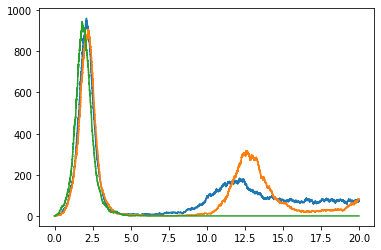

In [81]:
%%time

#Stochastic Solution #

for i in range(m):
    
    S = np.array([S_0])
    I = np.array([I_0])
    R = np.array([R_0])
    N = np.array([N_0])
    F = np.array([F_0])
    t = np.array([0])
    
    while t[-1] < t_max:
        
        X = [S[-1], I[-1], R[-1], N[-1], F[-1]]
        
        [newS, newI, newR, newN, newF, newt] = f(X, t[-1])
        
        S = np.append(S, newS)
        I = np.append(I, newI)
        R = np.append(R, newR)
        N = np.append(N, newN)
        F = np.append(F, newF)
        t = np.append(t, newt)
        
    plt.plot(t,I)